# Analyse BlueSeis BSPF Events

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth

from functions.request_data import __request_data
from functions.compute_adr_pfo import __compute_adr_pfo
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

# BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

# specify event
config['name'] = "M62"
config['tbeg'] = obs.UTCDateTime("2022-11-22 16:40:00")
config['tend'] = obs.UTCDateTime("2022-11-22 16:42:30")

# specify path for figures
config['path_to_figs'] = data_path+f"manuscripts/manuscript_bspf/figures/{config['name']}/"

# specify path to data
config['path_to_data'] = data_path+"manuscripts/manuscript_bspf/data/"


## Load Data

In [4]:
from functions.get_event_info import __get_event_info

In [5]:
event = Client("USGS").get_events(starttime=config['tbeg']-600, endtime=config['tend'], minmagnitude=6.0)
print(event)

event = event[0]

# Eventtime
config['eventtime'] = event.origins[0].time

dist, az, baz = gps2dist_azimuth(event.origins[0].latitude, event.origins[0].longitude,
                                 config['BSPF_lat'], config['BSPF_lon'],
                                 )
dist/1000, az, baz

1 Event(s) in Catalog:
2022-11-22T16:39:05.789000Z | +30.794, -116.391 | 6.2  mww | manual


(312.4427726684824, 358.8977338594426, 178.8632234903398)

## Load Waveforms

In [6]:
from functions.get_stream import __get_stream

In [7]:
# st0 = __get_stream(config['tbeg'], config['tend'])

# st0.write(config['path_to_data']+f"event{config['name']}_6c.mseed", format="MSEED")

# st0.plot(equal_scale=False);

In [8]:
st0 = obs.read(config['path_to_data']+f"event{config['name']}_6c.mseed")

st0.trim(st0[0].stats.starttime, st0[0].stats.endtime)

15 Trace(s) in Stream:
II.PFO.10.BHE  | 2022-11-22T16:39:59.994538Z - 2022-11-22T16:42:29.994538Z | 40.0 Hz, 6001 samples
II.PFO.10.BHN  | 2022-11-22T16:39:59.994538Z - 2022-11-22T16:42:29.994538Z | 40.0 Hz, 6001 samples
II.PFO.10.BHZ  | 2022-11-22T16:39:59.994538Z - 2022-11-22T16:42:29.994538Z | 40.0 Hz, 6001 samples
II.RPFO.al.BJE | 2022-11-22T16:39:59.996685Z - 2022-11-22T16:42:29.996685Z | 40.0 Hz, 6001 samples
II.RPFO.al.BJN | 2022-11-22T16:39:59.996685Z - 2022-11-22T16:42:29.996685Z | 40.0 Hz, 6001 samples
II.RPFO.al.BJZ | 2022-11-22T16:39:59.996685Z - 2022-11-22T16:42:29.996685Z | 40.0 Hz, 6001 samples
II.RPFO.in.BJE | 2022-11-22T16:39:59.996113Z - 2022-11-22T16:42:29.996113Z | 40.0 Hz, 6001 samples
II.RPFO.in.BJN | 2022-11-22T16:39:59.996113Z - 2022-11-22T16:42:29.996113Z | 40.0 Hz, 6001 samples
II.RPFO.in.BJZ | 2022-11-22T16:39:59.996113Z - 2022-11-22T16:42:29.996113Z | 40.0 Hz, 6001 samples
II.RPFO.mi.BJE | 2022-11-22T16:39:59.996506Z - 2022-11-22T16:42:29.996506Z | 40.0 Hz, 

In [9]:
submask = "mi"

bspf0 = st0.select(station="BSPF").copy()
pfo0 = st0.select(station="PFO*").copy()
adr0 = st0.select(station="RPFO", location=submask[:2]).copy()

if submask == "in":
    config['fmin'], config['fmax'] = 1.0, 6.0
elif submask == "mi":
    config['fmin'], config['fmax'] = 0.5, 1.0
elif submask == "al":
    config['fmin'], config['fmax'] = 0.1, 0.5

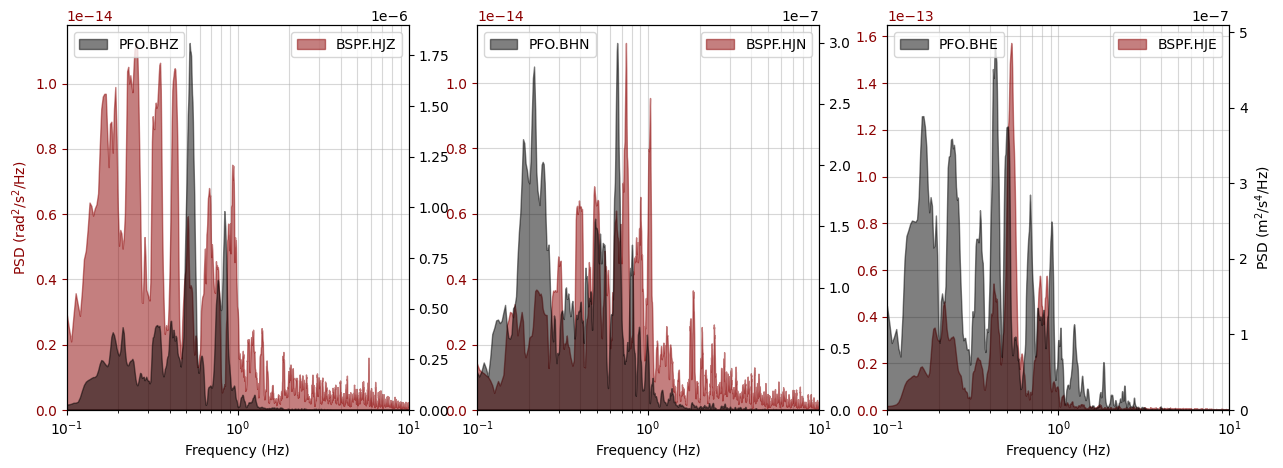

In [10]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill

acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

rot = rot.detrend("simple")
acc = acc.detrend("simple")

fig = __makeplot_spectra_comparison_fill(rot, acc, fmin=0.1, fmax=10, ylog=False, xlog=True, fill=True)

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_spectra_all.png", format="png", dpi=150, bbox_inches='tight');


## Create stream for all data

In [11]:
from functions.makeplot_waveform_comparison_all import __makeplot_waveform_comparison_all

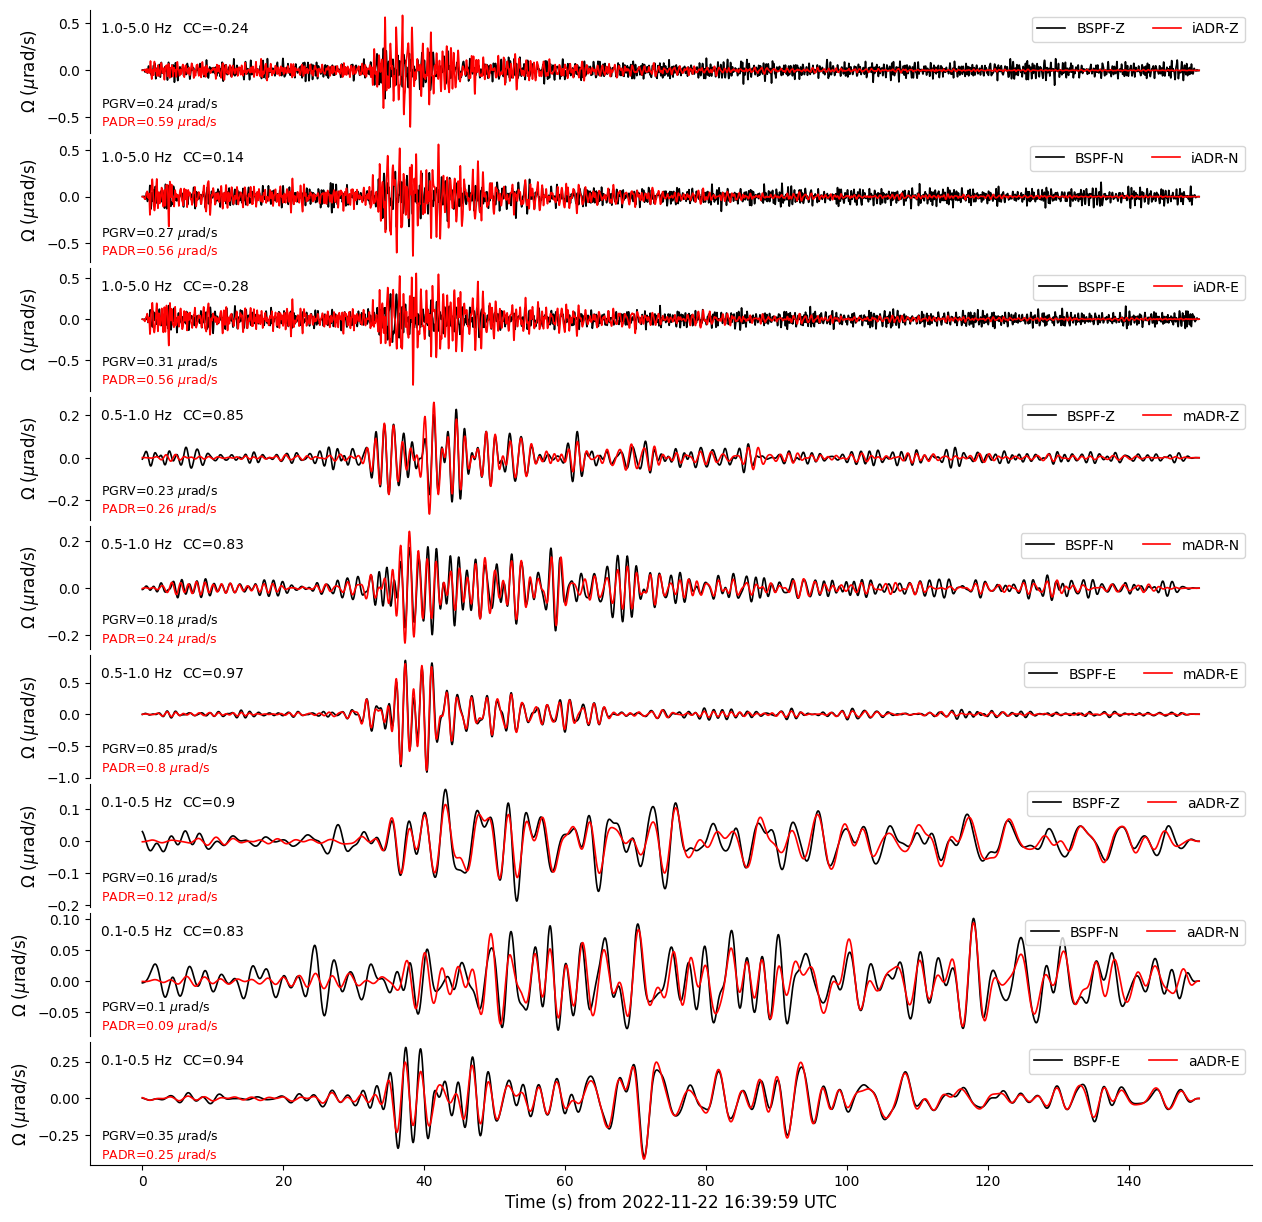

In [12]:
fig = __makeplot_waveform_comparison_all(st0);

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_waveforms_all.png", format="png", dpi=150, bbox_inches='tight');


In [13]:
def __makeplot_waveform_comparison(st_in):

    from obspy.signal.cross_correlation import correlate
    import numpy as np
    import matplotlib.pyplot as plt

    st = st_in.copy()

    # st = st.trim(st[0].stats.starttime+5, st[0].stats.endtime-15).copy()

    fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    lw = 1.2

    font = 16

    fbands = {"in":(1.0, 5.0), "mi":(0.5, 1.0), "al":(0.1, 0.5)}

    offset = [0, 0, 0]

    plt.subplots_adjust(hspace=0.05)

    scaling, unit = 1e6, f"$\mu$rad/s"

    idx = 0
    for _m, array in enumerate(["mi"]):

        fband = fbands[array]

        _adr = st.select(location=array).copy()
        _bspf = st.select(station="BSPF").copy()

        _bspf = _bspf.detrend("simple").taper(0.01).filter("bandpass", freqmin=fband[0], freqmax=fband[1], corners=4, zerophase=True)
        _adr = _adr.detrend("simple").taper(0.01).filter("bandpass", freqmin=fband[0], freqmax=fband[1], corners=4, zerophase=True)

        for _k, comp in enumerate(["Z", "N", "E"]):

            ax[idx].plot(_bspf.select(channel=f"*{comp}")[0].times(), _bspf.select(channel=f"*{comp}")[0].data*scaling, label=f"BSPF-{comp}", color="k", lw=lw)
            ax[idx].plot(_adr.select(channel=f"*{comp}")[0].times(), _adr.select(channel=f"*{comp}")[0].data*scaling, label=f"{array[0]}ADR-{comp}", color="r", lw=lw)

            cc = round(correlate(_bspf.select(channel=f"*{comp}")[0].data, _adr.select(channel=f"*{comp}")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 2)

            # rmse = np.round( np.sqrt( np.mean( ( ( _adr.select(channel=f"*{comp}")[0].data - _bspf.select(channel=f"*{comp}")[0].data )*scaling )**2 ) ), 3)

            ## pick peak rotation velocity
            pgrv = round(np.amax(_bspf.select(channel=f"*{comp}")[0].data*scaling), 2)

            ## pick peak adr
            padr = round(np.amax(_adr.select(channel=f"*{comp}")[0].data*scaling), 2)


            t1 = ax[idx].text(0.01, 0.9, f"{fband[0]}-{fband[1]} Hz", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)
            t1.set_bbox(dict(facecolor='white', alpha=0.7, linewidth=0))
            t2 = ax[idx].text(0.15, 0.9, f"CC={cc}", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)
            t2.set_bbox(dict(facecolor='white', alpha=0.7, linewidth=0))
            t3 = ax[idx].text(0.01, 0.30, f"PGRV={pgrv} {unit}", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-3)
            t3.set_bbox(dict(facecolor='white', alpha=0., linewidth=0))
            t4 = ax[idx].text(0.01, 0.15, f"PADR={padr} {unit}", ha='left', color="r", va='top', transform=ax[idx].transAxes, fontsize=font-3)
            t4.set_bbox(dict(facecolor='white', alpha=0., linewidth=0))

            ax[idx].legend(loc=1, ncols=4, fontsize=font-2)

            # ax[idx].grid(which="both", alpha=0.5)

            ax[idx].set_ylabel(f"$\Omega$ ({unit})", fontsize=font)
            ax[idx].xaxis.label.set_size(font-1)
            ax[idx].yaxis.label.set_size(font-1)

            if idx < 8:
                ax[idx].tick_params(axis='x', bottom=False)

            for pos in ["right", "top", "bottom"]:
                ax[idx].spines[pos].set_visible(False)

            idx += 1

    ax[idx-1].spines["bottom"].set_visible(True)

    ax[idx-1].set_xlabel(f"Time (s) from {st_in[0].stats.starttime.date} {str(st_in[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)

    # ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask} | CC$_Z$ = {cc_Z} | CC$_N$ = {cc_N} | CC$_E$ = {cc_E}")

    plt.show();
    return fig

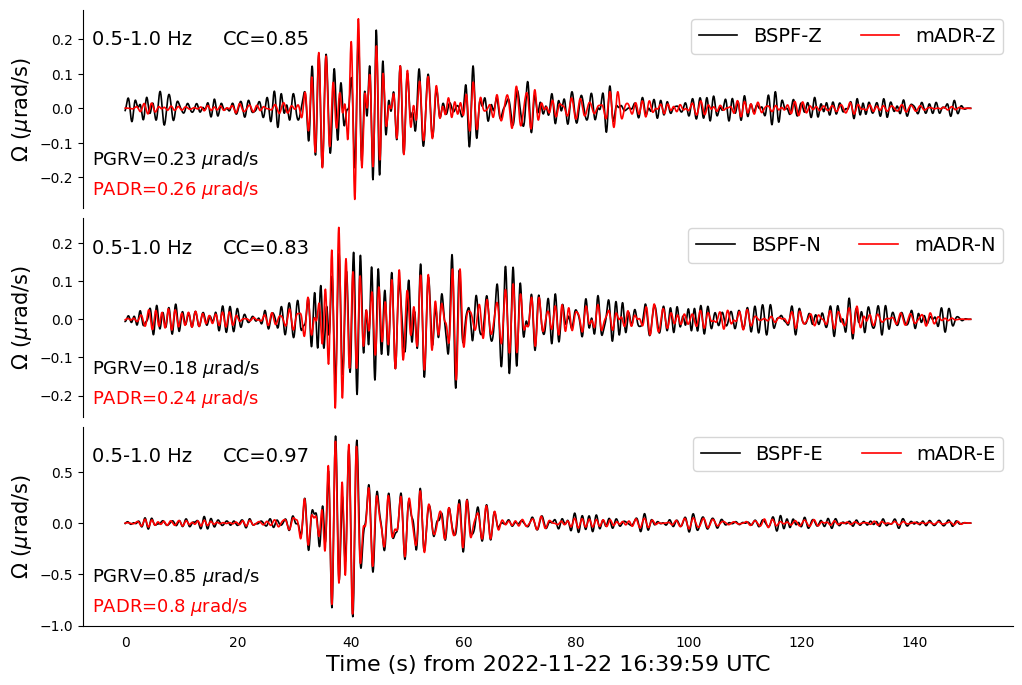

In [14]:
fig = __makeplot_waveform_comparison(st0);

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_waveforms_single.png", format="png", dpi=150, bbox_inches='tight');

### Specify Frequency Range

In [15]:
fmin, fmax = 0.5, 1.0

In [16]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

rot = rot.detrend("simple")
acc = acc.detrend("simple")

rot = rot.taper(0.01, type="cosine")
acc = acc.taper(0.01, type="cosine")

rot = rot.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
acc = acc.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

acc = acc.trim(config['tbeg']+9, config['tend']-5)
rot = rot.trim(config['tbeg']+9, config['tend']-5)

### Compare BSPF and ADR

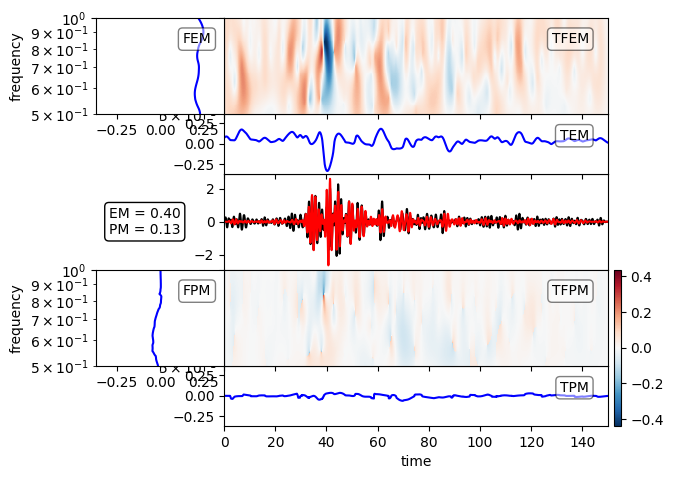

In [17]:
from scipy.signal import hilbert
from obspy.signal.tf_misfit import plot_tf_misfits

component = "Z"
array = "mi"

fmin, fmax = 0.5, 1.0

st1 = st0.copy()

st1 = st1.detrend("demean").taper(0.01, type="cosine")
st1 = st1.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

s1 = st1.select(station="BSPF", channel=f"*{component}")[0].data
s2 = st1.select(station="RPFO", location=array, channel=f"*{component}")[0].data
# s2 = st1.select(station="PFOIX", channel="*T")[0].data

dt = st1[0].stats.delta

plot_tf_misfits(s1, s2, dt=dt, fmin=fmin, fmax=fmax, show=True, norm="global")


In [18]:
# acc = st0.select(station="PFO*").copy()
# rot = st0.select(station="BSPF").copy()

# for tr in acc:
#     if "Z" in tr.stats.channel:
#         tr.data *= -1

# fmin, fmax = 0.5, 1.0
# # fmin, fmax = 1.0, 6.0

# rot = rot.detrend("demean").taper(0.01, type="cosine").filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
# acc = acc.detrend("demean").taper(0.01, type="cosine").filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)



In [19]:
from functions.makeplot_waveform_comparison_cc import __makeplot_waveform_comparison_cc

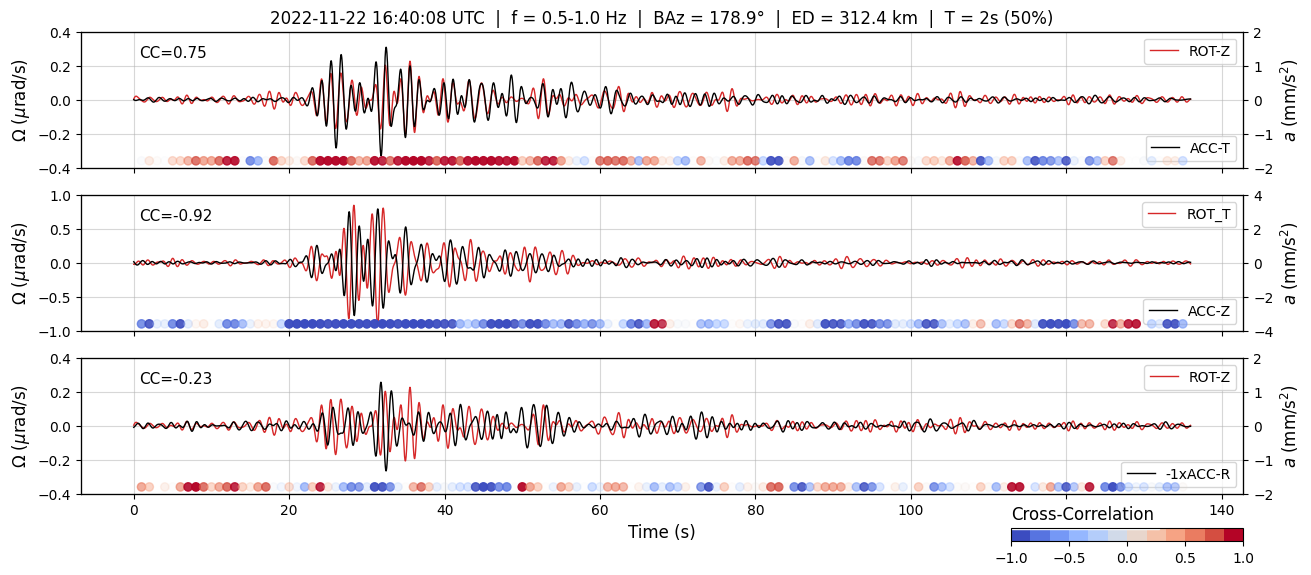

In [20]:
fig = __makeplot_waveform_comparison_cc(rot, acc, baz, fmin, fmax, dist, twin_sec=2, twin_overlap=0.5)

# fig.savefig(config['path_to_figs']+f"BSPF_{name}_waveforms_cc.png", format="png", dpi=150, bbox_inches='tight');


### Wavelet Comparsion

In [21]:
from functions.compute_cwt import __compute_cwt

set frequency limit: 5


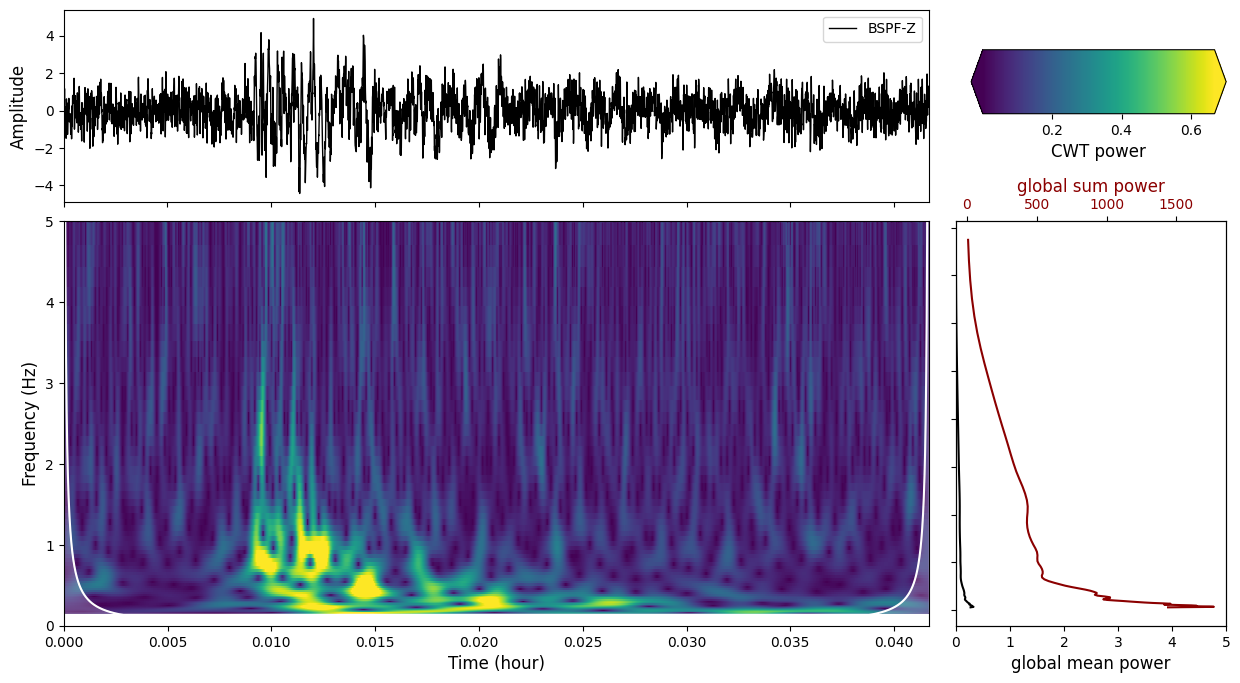

In [22]:
component = "Z"

acc0 = st0.select(station="PFO*").copy()
rot0 = st0.select(station="BSPF").copy()

ttt = rot0[0].times()
arr = rot0.select(channel=f"*{component}")[0].data
dt = rot0[0].stats.delta # seconds

out = __compute_cwt(ttt, arr, dt, tscale="hour",
                    datalabel=f"BSPF-{component}",
                    period=False,
                    ymax=5,
                    plot=True,
                   )

# out['fig'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_cwt_{component}.png", format="png", dpi=150, bbox_inches='tight');


## Backazimuth Estimate

In [23]:
from functions.compute_backazimuth import __compute_backazimuth
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [24]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude'] = config['BSPF_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 1/fmin

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 75

## specify steps for degrees of baz
config['step'] = 1

## specify event info
config['event'] = event

baz, az, dist = __get_theoretical_backazimuth(config['BSPF_lat'], config['BSPF_lon'], event_obj=event, fdsn_client='USGS')


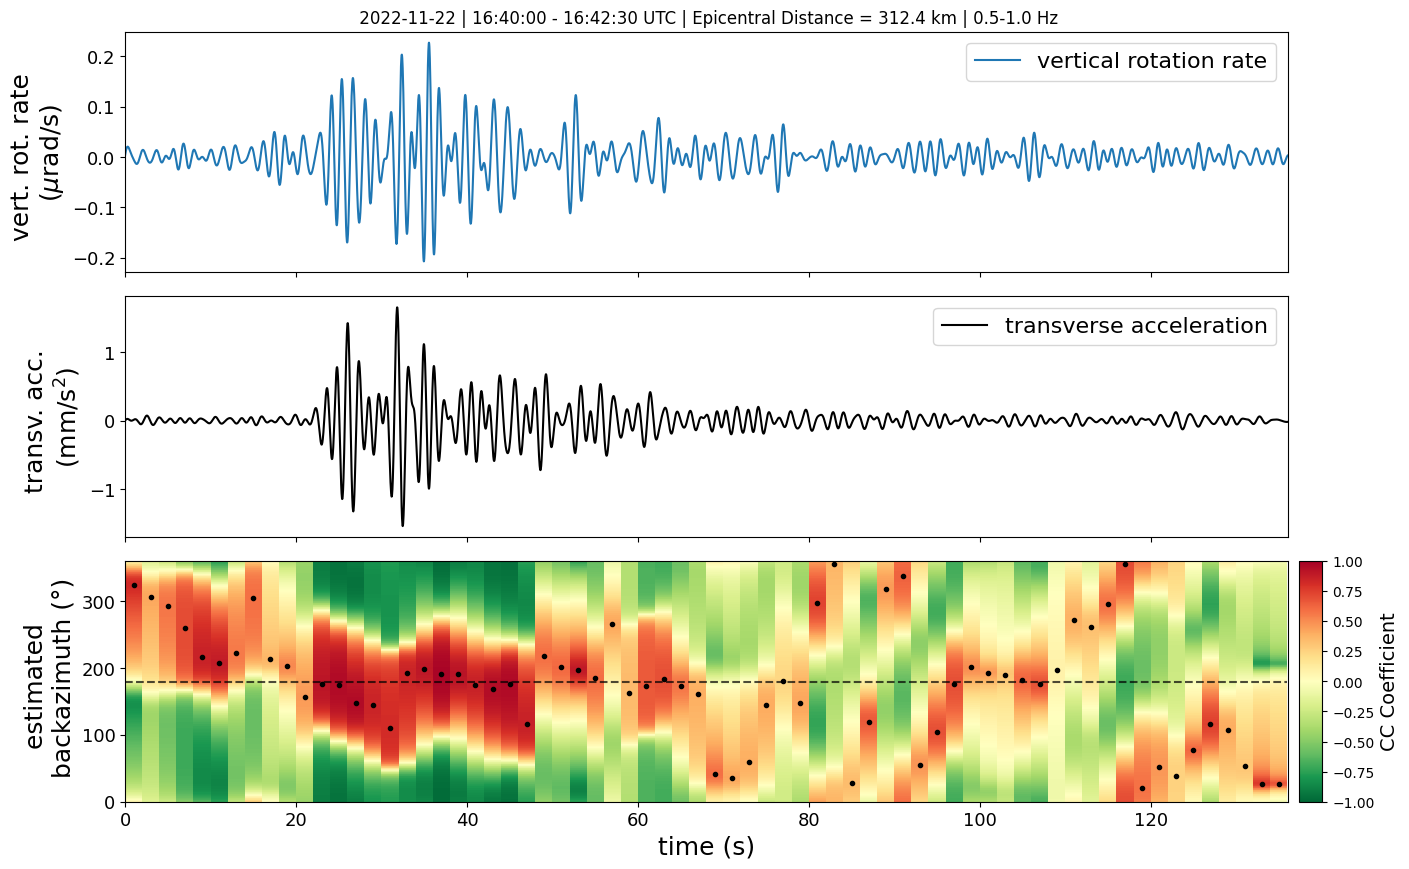

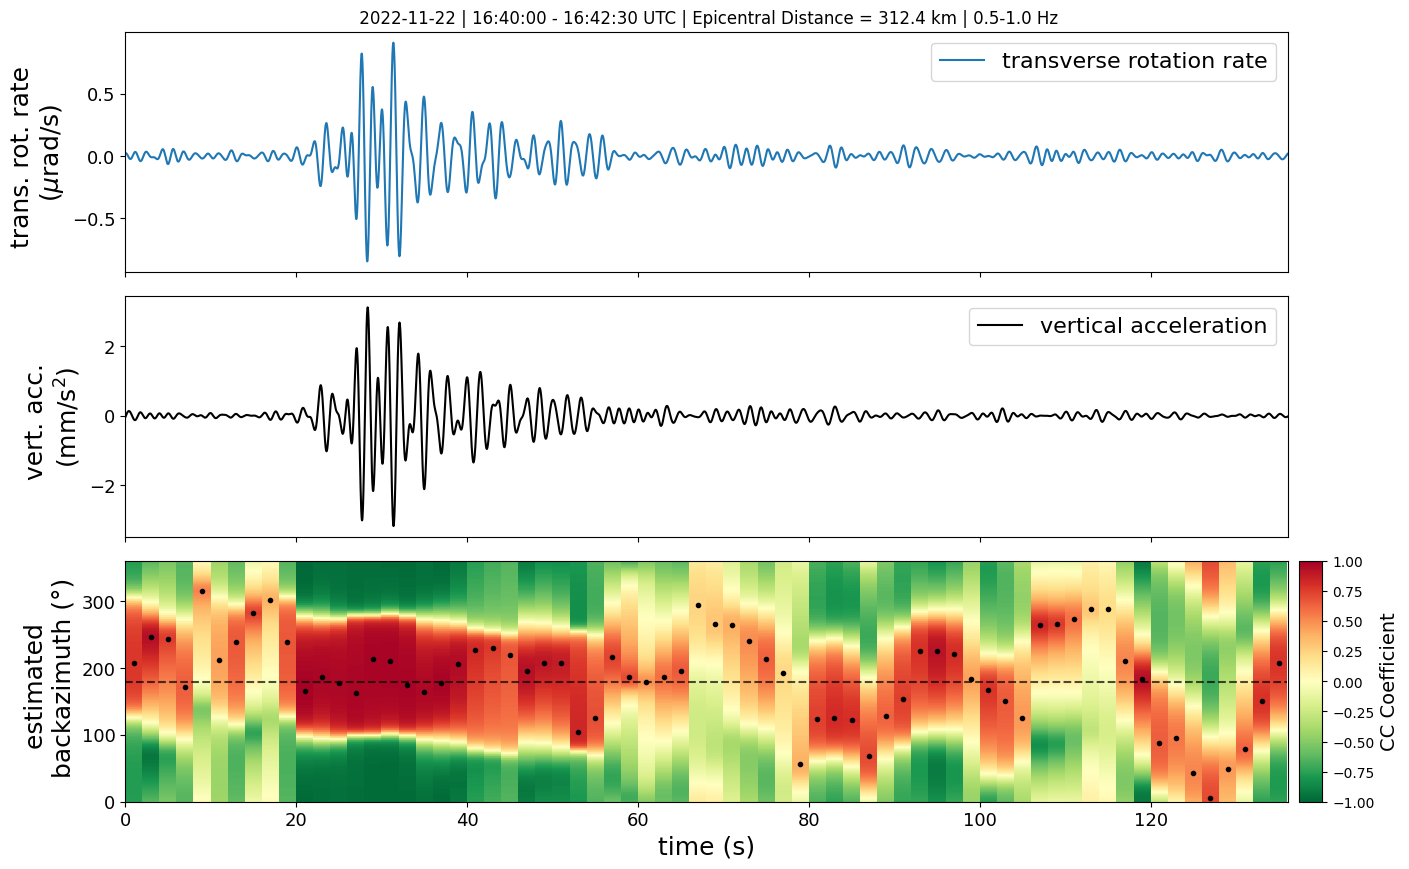

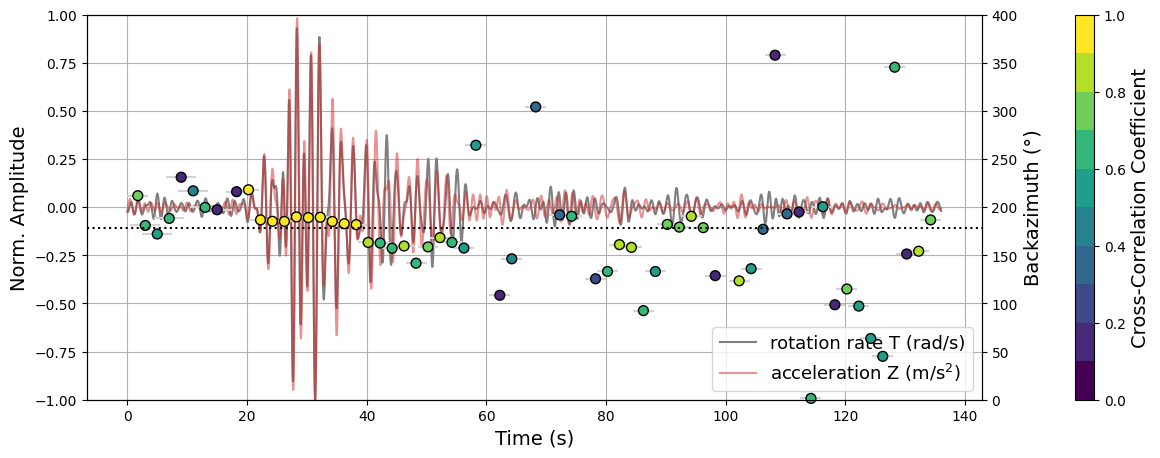

In [25]:
out1 = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='love',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            invert_rot_z=False,
                            show_details=False,
)

# out1['fig'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_love_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out2 = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='rayleigh',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            invert_acc_z=True,
                            show_details=False,
)

# out2['fig'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_rayleigh_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out3 = __compute_backazimuth_tangent(
                                    rot,
                                    acc,
                                    win_time_s=config['win_length_sec'],
                                    overlap=config['overlap']/100,
                                    baz_theo=baz,
                                    cc_thres=0.1,
                                    plot=True,
                                    invert_acc_z=True,
                                    )

# out3['fig'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_tangent_{rot[0].stats.station}{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


In [26]:
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [27]:
def __compare_backazimuth_codes(rot0, acc0, cat_event, fmin, fmax, Twin, Toverlap, cc_thres=None, invert_acc_z=False, plot=False):

    import scipy.stats as sts
    import matplotlib.pyplot as plt

    from numpy import ones, linspace, histogram, concatenate, average, argmax, isnan, sqrt, cov, nan, array, arange
    from obspy import UTCDateTime
    from obspy.signal.rotate import rotate_ne_rt
    from functions.compute_backazimuth import __compute_backazimuth
    from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

    rot = rot0.copy()
    acc = acc0.copy()

    rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax)
    acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax)

    config = {}

    config['tbeg'] = rot[0].stats.starttime
    config['tend'] = rot[0].stats.endtime

    ## Eventtime
    config['eventtime'] = UTCDateTime(cat_event.origins[0].time)

    ## specify coordinates of station
    config['station_longitude'] =  -116.455439
    config['station_latitude']  = 33.6106

    ## specify window length for baz estimation in seconds
    config['win_length_sec'] = Twin

    ## define an overlap for the windows in percent (50 -> 50%)
    config['overlap'] = Toverlap

    ## specify steps for degrees of baz
    config['step'] = 1


    out1 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='rayleigh',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    out2 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='love',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    out3 = __compute_backazimuth_tangent(
                                        rot,
                                        acc,
                                        win_time_s= config['win_length_sec'],
                                        overlap=config['overlap']/100,
                                        baz_theo=out2['baz_theo'],
                                        cc_thres=0,
                                        plot=False,
                                        invert_acc_z=invert_acc_z,
    )

    ## filter according to cc-threshold
    if cc_thres:
        for ii, _cc in enumerate(out1['cc_max']):
            if abs(_cc) <= cc_thres:
                out1['cc_max'][ii], out1['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out2['cc_max']):
            if abs(_cc) <= cc_thres:
                out2['cc_max'][ii], out2['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out3['ccoef']):
            if abs(_cc) <= cc_thres:
                out3['ccoef'][ii], out3['baz_est'][ii] = nan, nan



    ## compute statistics
    deltaa = 10
    angles = arange(0, 365, deltaa)
    angles2 = arange(0, 365, 1)

    ## ______________________________________
    ## Rayleigh
    try:
        baz_rayleigh_no_nan = out1['cc_max_y'][~isnan(out1['cc_max_y'])]
        cc_rayleigh_no_nan = out1['cc_max'][~isnan(out1['cc_max'])]

        hist = histogram(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)

        baz_rayleigh_mean = round(average(baz_rayleigh_no_nan, weights=cc_rayleigh_no_nan), 0)
        baz_rayleigh_std = sqrt(cov(baz_rayleigh_no_nan, aweights=cc_rayleigh_no_nan))

        # baz_rayleigh_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde1 = sts.gaussian_kde(baz_rayleigh_no_nan, weights=baz_rayleigh_no_nan)
        baz_rayleigh_max = angles2[argmax(kde1.pdf(angles2))]

        ## ______________________________________
        ## Love
        baz_love_no_nan = out2['cc_max_y'][~isnan(out2['cc_max_y'])]
        cc_love_no_nan = out2['cc_max'][~isnan(out2['cc_max'])]

        hist = histogram(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)

        baz_love_mean = round(average(baz_love_no_nan, weights=cc_love_no_nan), 0)
        baz_love_std = sqrt(cov(baz_love_no_nan, aweights=cc_love_no_nan))

        # baz_love_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde2 = sts.gaussian_kde(baz_love_no_nan, weights=cc_love_no_nan)
        baz_love_max = angles2[argmax(kde2.pdf(angles2))]

        ## ______________________________________
        ## Tangent
        baz_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]
        cc_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]

        hist = histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)

        baz_tangent_mean = round(average(baz_tangent_no_nan, weights=cc_tangent_no_nan), 0)
        baz_tangent_std = sqrt(cov(baz_tangent_no_nan, aweights=cc_tangent_no_nan))

        # baz_tangent_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde3 = sts.gaussian_kde(baz_tangent_no_nan, weights=cc_tangent_no_nan)
        baz_tangent_max = angles2[argmax(kde3.pdf(angles2))]

    except Exception as e:
        print(e)
        pass

    if plot:

        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec

        Ncol, Nrow = 8, 6

        fig3 = plt.figure(figsize=(12, 10))

        gs = GridSpec(Nrow, Ncol, figure=fig3, hspace=0.15)

        ax0 = fig3.add_subplot(gs[0, :])
        ax1 = fig3.add_subplot(gs[1, :])
        ax2 = fig3.add_subplot(gs[2, :])

        ax3 = fig3.add_subplot(gs[3, :])
        ax4 = fig3.add_subplot(gs[4, :])
        ax5 = fig3.add_subplot(gs[5, :])

        ax6 = fig3.add_subplot(gs[3, 7:])
        ax7 = fig3.add_subplot(gs[4, 7:])
        ax8 = fig3.add_subplot(gs[5, 7:])

        ax6.set_axis_off()
        ax7.set_axis_off()
        ax8.set_axis_off()

        for _ax in [ax0, ax1, ax2, ax3, ax4]:
            _ax.set_xticklabels([])

        rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
        trans_scaling, trans_unit = 1e3, r"mm/s$^2$"

        font = 12

        hz = acc.select(channel="*HZ")[0]
        hn = acc.select(channel="*HN")[0]
        he = acc.select(channel="*HE")[0]

        jz = rot.select(channel="*JZ")[0]
        jn = rot.select(channel="*JN")[0]
        je = rot.select(channel="*JE")[0]

        hr, ht = rotate_ne_rt(hn.data, he.data, out3['baz_theo'])
        jr, jt = rotate_ne_rt(jn.data, je.data, out3['baz_theo'])

        ## reverse polarity of transverse rotation!!
        # jt *= -1
        hr *= -1

        t1, t2 = hz.times().min(), hz.times().max()

        ax0.plot(hz.times(), (ht)*trans_scaling, 'black', label=f"PFO.T")
        ax1.plot(hz.times(), (hz.data)*trans_scaling, 'black', label=f"PFO.Z")
        ax2.plot(hz.times(), hr*trans_scaling, 'black', label=f"-1x PFO.R")

        ax0.set_ylim(-max(abs((ht)*trans_scaling)), max(abs((ht)*trans_scaling)))
        ax1.set_ylim(-max(abs((hz.data)*trans_scaling)), max(abs((hz.data)*trans_scaling)))
        ax2.set_ylim(-max(abs(hr*trans_scaling)), max(abs(hr*trans_scaling)))

        ax00 = ax0.twinx()
        ax00.plot(jz.times(), jz.data*rot_scaling, 'darkred', label=r"BSPF.Z")

        ax11 = ax1.twinx()
        ax11.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"BSPF.T")

        ax22 = ax2.twinx()
        ax22.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"BSPF.T")

        ax00.set_ylim(-max(abs(jz.data*rot_scaling)), max(abs(jz.data*rot_scaling)))
        ax11.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))
        ax22.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))

        cmap = plt.get_cmap("viridis", 10)

        ca3 = ax3.scatter(out1['cc_max_t'], out1['cc_max_y'], c=out1['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ca4 = ax4.scatter(out2['cc_max_t'], out2['cc_max_y'], c=out2['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ca5 = ax5.scatter(out3['t_win_center'], out3['baz_est'], c=out3['ccoef'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        cax3 = ax3.inset_axes([1.01, 0., 0.02, 1])
        cb3 = plt.colorbar(ca3, ax=ax3, cax=cax3)
        cb3.set_label("CC-Coeff.", fontsize=font)

        cax4 = ax4.inset_axes([1.01, 0., 0.02, 1])
        cb4 = plt.colorbar(ca4, ax=ax4, cax=cax4)
        cb4.set_label("CC-Coeff.", fontsize=font)

        cax5 = ax5.inset_axes([1.01, 0., 0.02, 1])
        cb5 = plt.colorbar(ca5, ax=ax5, cax=cax5)
        cb5.set_label("CC-Coeff.", fontsize=font)

        ax3.set_ylabel(f"Rayleigh BAz.(°)", fontsize=font)
        ax4.set_ylabel(f"Love BAz.(°)", fontsize=font)
        ax5.set_ylabel(f"CoVar. BAz.(°)", fontsize=font)

        ax66 = ax6.twinx()
        ax66.hist(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out1['cc_max'], orientation="horizontal", density=True, color="grey")
        ax66.plot(kde1.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax66.axhline(baz_rayleigh_max, color="k", ls="--")
        ax66.set_axis_off()
        ax66.yaxis.tick_right()
        ax66.invert_xaxis()

        ax77 = ax7.twinx()
        ax77.hist(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out2['cc_max'], orientation="horizontal", density=True, color="grey")
        ax77.plot(kde2.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax77.axhline(baz_love_max, color="k", ls="--")
        ax77.set_axis_off()
        ax77.yaxis.tick_right()
        ax77.invert_xaxis()

        ax88 = ax8.twinx()
        ax88.hist(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out3['ccoef'], orientation="horizontal", density=True, color="grey")
        ax88.plot(kde3.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax88.axhline(baz_tangent_max, color="k", ls="--")
        ax88.set_axis_off()
        ax88.yaxis.tick_right()
        ax88.invert_xaxis()


        ax0.set_yticks(linspace(ax0.get_yticks()[0], ax0.get_yticks()[-1], len(ax0.get_yticks())))
        ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax0.get_yticks())))

        ax1.set_yticks(linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax1.get_yticks())))
        ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax1.get_yticks())))

        ax2.set_yticks(linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax2.get_yticks())))
        ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax2.get_yticks())))

        for _ax in [ax0, ax1, ax2]:
            _ax.grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            _ax.legend(loc=1)
            _ax.set_ylabel(f"a ({trans_unit})", fontsize=font)
            _ax.set_xlim(0, (config['tend']-config['tbeg'])*1.15)
            _ax.xaxis.label.set_size(font-1)
            _ax.yaxis.label.set_size(font-1)

        for _ax in [ax3 ,ax4, ax5]:
            _ax.set_ylim(-5, 365)
            _ax.set_yticks(range(0, 360+60,60))
            _ax.grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            _ax.set_xlim(0,  (config['tend']-config['tbeg'])*1.15)
            _ax.xaxis.label.set_size(font-1)
            _ax.yaxis.label.set_size(font-1)

            _ax.plot([t1, t2], ones(2)*out3['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)
            _ax.fill_between([t1, t2], ones(2)*out3['baz_theo']-10, ones(2)*out3['baz_theo']+10, lw=1.5, alpha=0.5, color="grey", zorder=1)

        for aaxx in [ax00, ax11, ax22]:
            aaxx.tick_params(axis='y', colors="darkred")
            aaxx.set_ylabel(f"$\Omega$ ({rot_unit})", color="darkred", fontsize=font)
            aaxx.legend(loc=4)
            _ax.xaxis.label.set_size(font-1)
            _ax.yaxis.label.set_size(font-1)

        ax0.set_title(f" {config['tbeg'].date}  {str(config['tbeg'].time).split('.')[0]}-{str(config['tend'].time).split('.')[0]} UTC | f = {fmin}-{fmax} Hz | T = {config['win_length_sec']} s | {config['overlap']} % overlap")

        ax5.set_xlabel("Time (s)", fontsize=font)

        plt.show();


    ## prepare output directory
    out = {}
    out['baz_theo'] = round(out2['baz_theo'], 0)
    out['baz_angles'] = angles
    out['baz_tangent_max'] = baz_tangent_max
    out['baz_tangent_mean'] = baz_tangent_mean
    out['baz_tangent_std'] = baz_tangent_std
    out['baz_rayleigh_max'] = baz_rayleigh_max
    out['baz_rayleigh_mean'] = baz_rayleigh_mean
    out['baz_rayleigh_std'] = baz_rayleigh_std
    out['baz_love_max'] = baz_love_max
    out['baz_love_mean'] = baz_love_mean
    out['baz_love_std'] = baz_love_std


    if plot:
        out['fig3'] = fig3

    return out

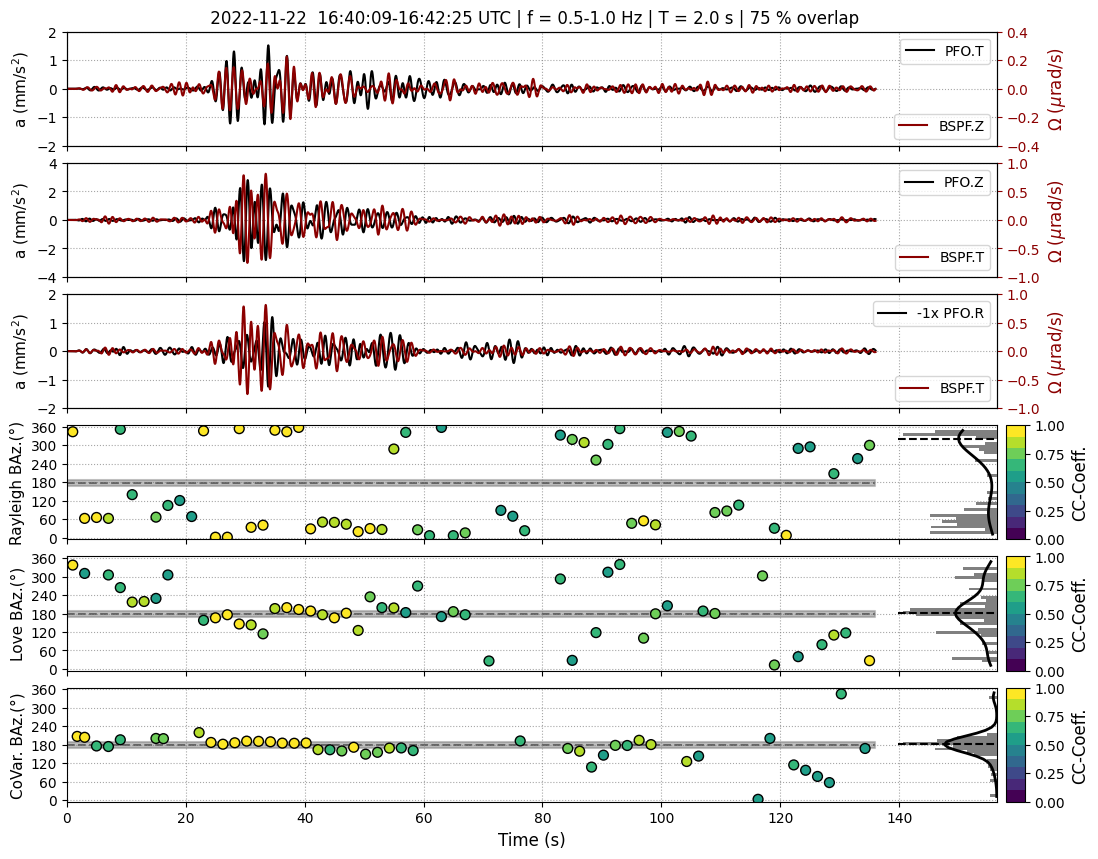

In [28]:
out4 = __compare_backazimuth_codes(rot, acc, event, fmin, fmax, config['win_length_sec'], config['overlap'], cc_thres=0.5, invert_acc_z=True, plot=True);

out4['fig3'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_all.png", dpi=150, bbox_inches='tight', pad_inches=0.05);


## Compare backazimuth estimate for ADR, BSPF and Beamforming

In [29]:
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

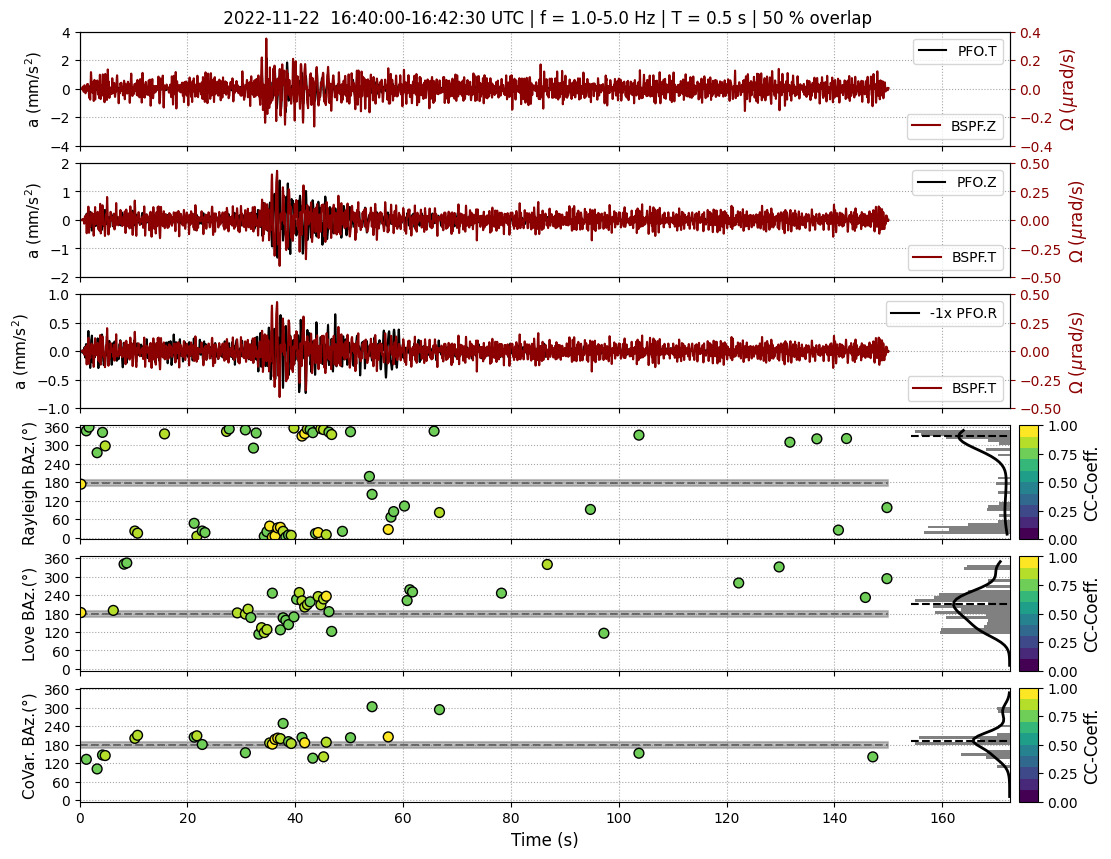

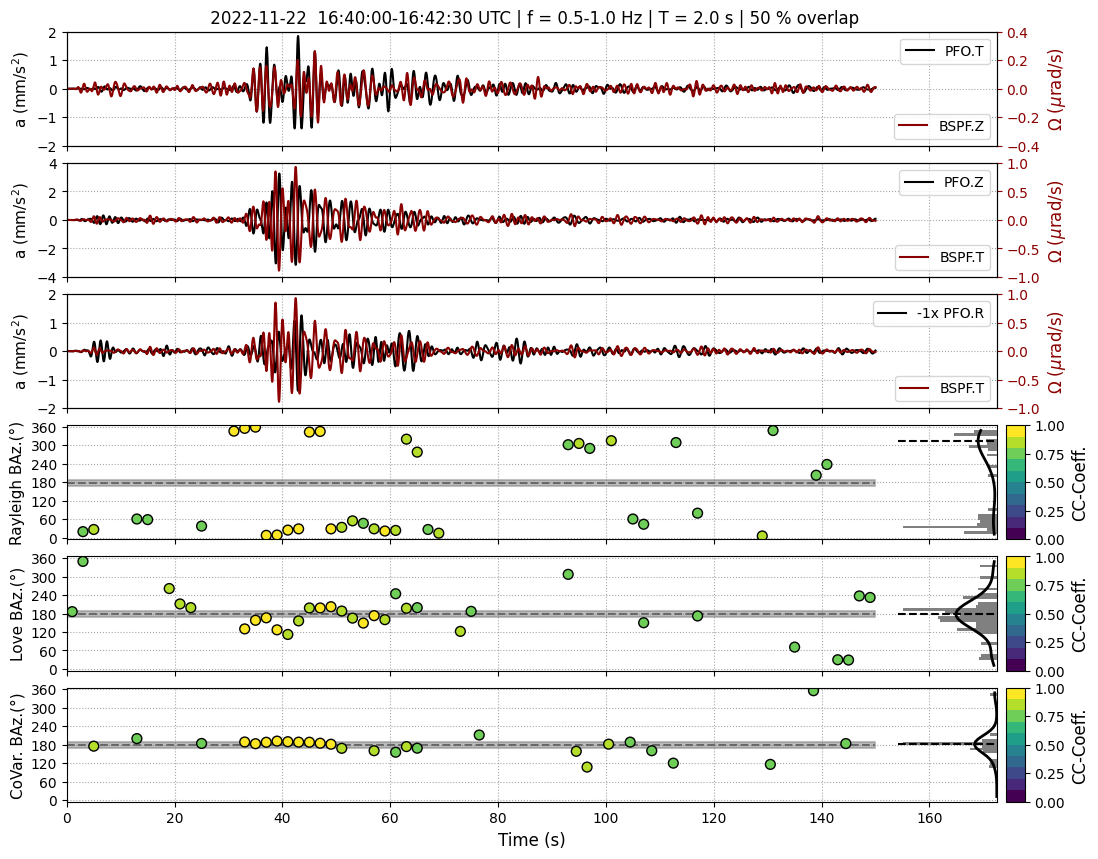

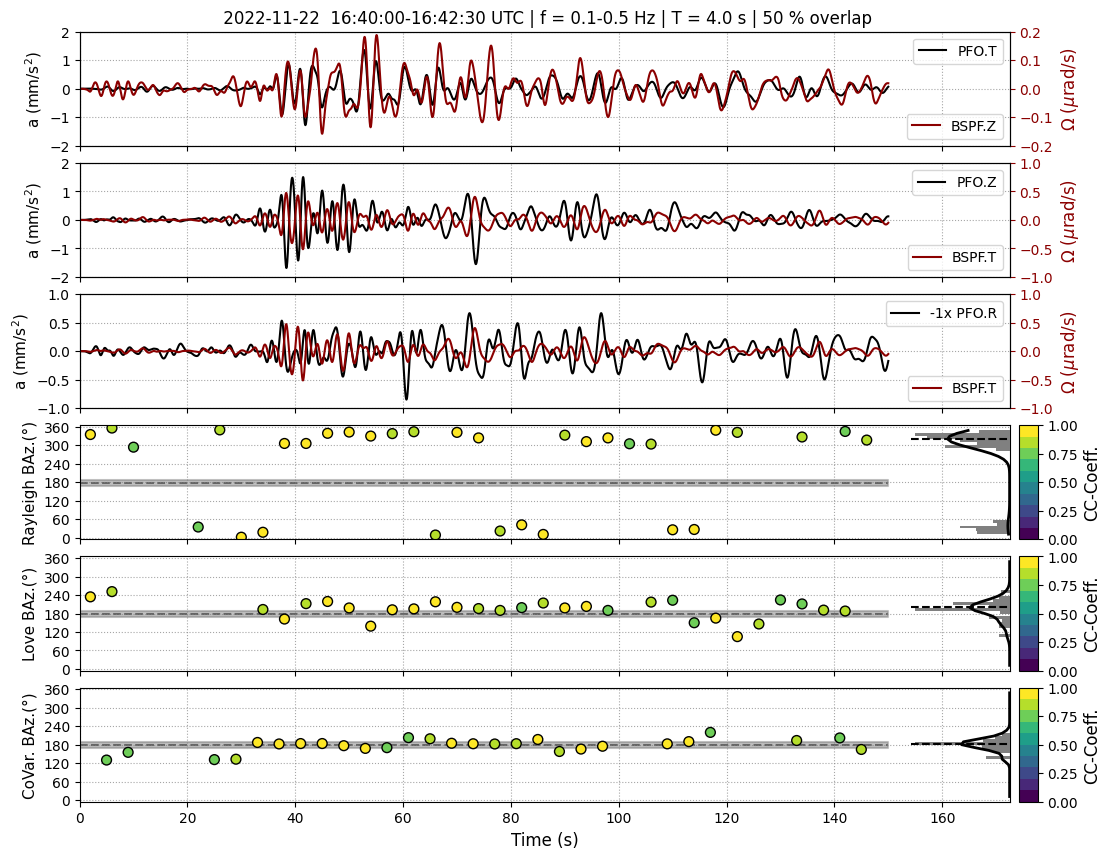

 -> obtained: 3 of 3 stations!

 -> Runtime: 0.37 minutes
 -> obtained: 6 of 6 stations!

 -> Runtime: 1.12 minutes
 -> obtained: 11 of 11 stations!

 -> Runtime: 1.63 minutes


In [30]:
stt = st0.copy();

acc0 = stt.copy().select(station="PFO*");
rot0 = stt.copy().select(station="BSPF");

cc_thres = 0.7

Twin_factor = 1
Twin_overlap = 50

## direct rotation
out_bspf_i = __compare_backazimuth_codes(rot0, acc0, event, 1.0, 5.0, Twin_factor/2.0, Twin_overlap,
                                         cc_thres=cc_thres, invert_acc_z=True, plot=True);
out_bspf_i['fig3'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_comparison_{rot[0].stats.location}_2.0_5.0_all.png",
                           dpi=200, bbox_inches='tight', pad_inches=0.05);

out_bspf_m = __compare_backazimuth_codes(rot0, acc0, event, 0.5, 1.0, Twin_factor/0.5, Twin_overlap,
                                         cc_thres=cc_thres, invert_acc_z=True, plot=True);
out_bspf_m['fig3'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_comparison_{rot[0].stats.location}_0.5_1.0_all.png",
                           dpi=200, bbox_inches='tight', pad_inches=0.05);

out_bspf_a = __compare_backazimuth_codes(rot0, acc0, event, 0.1, 0.5, Twin_factor/0.25, Twin_overlap,
                                         cc_thres=cc_thres, invert_acc_z=True, plot=True);
out_bspf_a['fig3'].savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_comparison_{rot[0].stats.location}_0.1_0.5_all.png",
                           dpi=200, bbox_inches='tight', pad_inches=0.05);


## adr rotation
rot1 = stt.copy().select(station="RPFO", location="in");
out_adr_i = __compare_backazimuth_codes(rot1, acc0, event, 1.0, 5.0, Twin_factor/2.0, Twin_overlap,
                                        cc_thres=cc_thres, invert_acc_z=True, plot=False);

rot2 = stt.copy().select(station="RPFO", location="mi");
out_adr_m = __compare_backazimuth_codes(rot2, acc0, event, 0.5, 1.0, Twin_factor/0.5, Twin_overlap,
                                        cc_thres=cc_thres, invert_acc_z=True, plot=False);

rot3 = stt.copy().select(station="RPFO", location="al");
out_adr_a = __compare_backazimuth_codes(rot3, acc0, event, 0.1, 0.5, Twin_factor/0.25, Twin_overlap,
                                        cc_thres=cc_thres, invert_acc_z=True, plot=False);

## array beamforming
out_bf_i = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=1.0, fmax=5.0,
                                     component="Z", submask="inner", plot=False)
out_bf_m = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.5, fmax=1.0,
                                     component="Z", submask="mid", plot=False)
out_bf_a = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.1, fmax=0.5,
                                     component="Z", submask="all", plot=False)
# out_bf_o = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.8, fmax=1.0,
#                                      component="Z", submask="mid", plot=False)


In [31]:
def __makeplot_comparison():

    labels = ["iBSPF", "iADR", "iBF", "mBSPF", "mADR", "mBF", "aBSPF", "aADR", "aBF"]

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    font = 16

    ax.axhline(out_bspf_i['baz_theo'], color="k", ls="--", label="theo. Baz.")
    ax.fill_between([-0.3, 4.0], out_bspf_i['baz_theo']-10, out_bspf_i['baz_theo']+10, color="grey", alpha=0.5, label="theo. Baz. +- 10°")


    for j, out in enumerate([out_adr_i, out_adr_m, out_adr_a]):

        ax.errorbar(j-0.02, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.02, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j-0.02, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.02, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")

        ## plot only for legend icon

        if j == 0:
            ax.scatter(j+0.4, out_bf_i['baz_bf_max'], color="tab:orange", zorder=2, label="beamforming", edgecolors="k")
            ax.legend(loc=1, fontsize=font-3)


    for j, out in enumerate([out_bspf_i, out_bspf_m, out_bspf_a]):

        ax.errorbar(j+0.18, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j+0.2, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.22, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j+0.18, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j+0.2, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.22, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")


    for j, out in enumerate([out_bf_i, out_bf_m, out_bf_a]):

        ax.errorbar(j+0.4, out['baz_bf_max'], yerr=out['baz_bf_std'], color="tab:orange", zorder=2)
        ax.scatter(j+0.4, out['baz_bf_max'], color="tab:orange", zorder=2, label="", edgecolors="k")



    ax.set_xticks([0,0.2,0.4,1,1.2,1.4,2,2.2,2.4], labels=labels, fontsize=font-1)

    ax.grid(axis="y", ls=":", color="k", alpha=0.5, zorder=0)

    ax.text(0, 360+10, "1.0 - 5.0 Hz", fontsize=font-1)
    ax.text(1, 360+10, "0.5 - 1.0 Hz", fontsize=font-1)
    ax.text(2, 360+10, "0.1 - 0.5 Hz", fontsize=font-1)
    # ax.text(3, 360+10, "0.8 - 1.0 Hz", fontsize=font-1)

    ax.xaxis.label.set_size(font-1)
    ax.yaxis.label.set_size(font-1)

    ax.set_ylim(-5, 365)
    ax.set_yticks(range(0, 360+60,60))

    ax.set_ylabel("Backazimuth (°)", fontsize=font)

    ax.set_xlim(-0.3, 3.0)
    ax.set_ylim(0, 360)

    plt.show();
    return fig

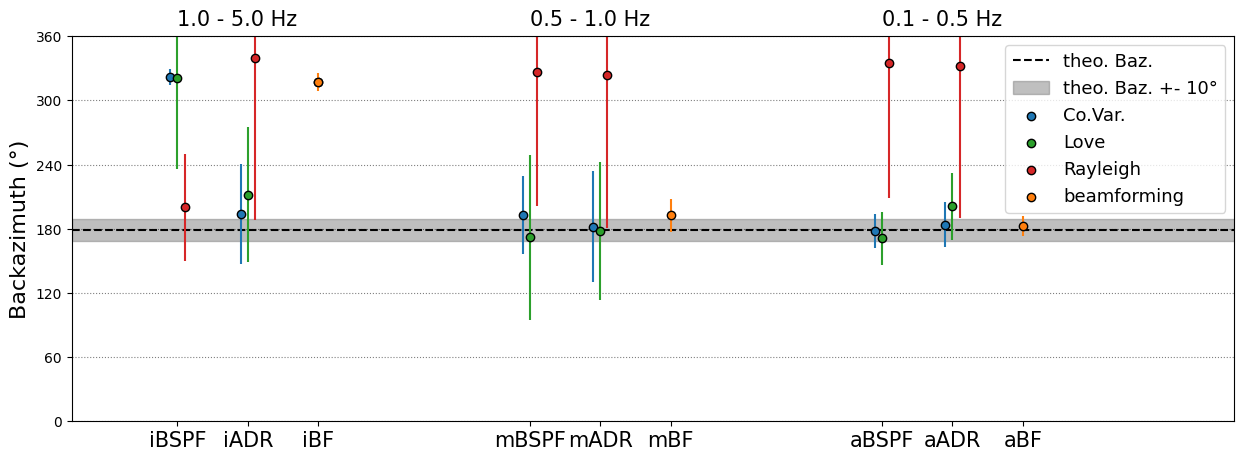

In [32]:
fig = __makeplot_comparison()

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_baz_comparison_overview.png", dpi=150, bbox_inches='tight', pad_inches=0.05);


## Phase Velocity

In [33]:
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [34]:
from functions.makeplot_velocities import __makeplotStream_velocities

In [35]:
def __makeplotStream_velocities(rot, acc, fmin, fmax, baz, overlap=0.5, cc_threshold=0.2, twin=None, reverse_rotZ=False, reverse_accZ=False):

    import matplotlib.pyplot as plt
    import numpy as np
    from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio
    from obspy.signal.rotate import rotate_ne_rt

    rot00 = rot.copy()
    acc00 = acc.copy()

    if reverse_rotZ:
        rot00.select(channel="*Z")[0].data *= -1

    if reverse_accZ:
        acc00.select(channel="*Z")[0].data *= -1

    rot00 = rot00.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4)
    acc00 = acc00.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4)

    df = rot00[0].stats.sampling_rate

    if not twin:
        twin=1/fmin

    out1 = __compute_velocity_from_amplitude_ratio(
                                                    rot00,
                                                    acc00,
                                                    baz=baz,
                                                    mode='love',
                                                    win_time_s=twin,
                                                    cc_thres=cc_threshold,
                                                    overlap=overlap,
                                                    flim=(fmin, fmax),
                                                    plot=False,
                                                    reverse_rotZ=False,
                                                    reverse_accZ=False,
                                                    )

    out2 = __compute_velocity_from_amplitude_ratio(
                                                    rot00,
                                                    acc00,
                                                    baz=baz,
                                                    mode='rayleigh',
                                                    win_time_s=twin,
                                                    cc_thres=cc_threshold,
                                                    overlap=overlap,
                                                    flim=(fmin, fmax),
                                                    plot=False,
                                                    reverse_rotZ=False,
                                                    reverse_accZ=False,
                                                    )

    rot_r, rot_t = rotate_ne_rt(rot00.select(channel='*N')[0].data,
                                rot00.select(channel='*E')[0].data,
                                baz
                                )
    acc_r, acc_t = rotate_ne_rt(acc00.select(channel='*N')[0].data,
                                acc00.select(channel='*E')[0].data,
                                baz
                                )

    rot_z = rot00.select(channel="*Z")[0].data
    rot_n = rot00.select(channel="*N")[0].data
    rot_e = rot00.select(channel="*E")[0].data

    acc_z = acc00.select(channel="*Z")[0].data
    acc_n = acc00.select(channel="*N")[0].data
    acc_e = acc00.select(channel="*E")[0].data

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 7), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    cmap = plt.get_cmap("viridis", 10)


    ## waveform axis
    if reverse_rotZ:
        ax[0].plot(np.array(range(len(rot_z)))/df, rot_z/max(abs(rot_z)), alpha=1, color="black", label="-1*$\Omega_Z$ (rad/s)")
    else:
        ax[0].plot(np.array(range(len(rot_z)))/df, rot_z/max(abs(rot_z)), alpha=1, color="black", label="$\Omega_Z$ (rad/s)")

    ax[0].plot(np.array(range(len(acc_t)))/df, acc_t/max(abs(acc_t)), alpha=1, color="tab:red", label=r"$a_T$ (m/s$^2$)")
    ax[2].plot(np.array(range(len(rot_t)))/df, rot_t/max(abs(rot_t)), alpha=1, color="black", label="$\Omega_T$ (rad/s)")

    if reverse_accZ:
        ax[2].plot(np.array(range(len(acc_z)))/df, acc_z/max(abs(acc_z)), alpha=1, color="tab:red", label=r"-1x $a_Z$ (m/s$^2$)")
    else:
        ax[2].plot(np.array(range(len(acc_z)))/df, acc_z/max(abs(acc_z)), alpha=1, color="tab:red", label=r"$a_Z$ (m/s$^2$)")


    ## velocity axis
    caa = ax[1].scatter(out1['time'], out1['velocity'], c=out1['ccoef'], s=50,
                        cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1,
                        label="phase velocity", zorder=2,
                        )

    ax[1].errorbar(out1['time'], out1['velocity'], xerr=out1['terr'], yerr=None,
                 zorder=1, color="black", alpha=0.4, marker='o', markersize=2, ls="None",
                )

    ax[1].set_ylabel(f"Love Phase \n Velocity (m/s)", fontsize=font)
    ax[1].set_ylim(bottom=0)
    # ax[1].set_yticks(np.linspace(ax0.get_yticks()[0], ax0.get_yticks()[-1], len(ax[0].get_yticks())))
    ax[1].legend(loc=4, fontsize=font-2)

    # cbar = plt.colorbar(caa, pad=0.08)
    # cbar.set_label("CC-Coefficient", fontsize=font)
    # # cbar.set_clip_on(False)

    caa = ax[3].scatter(out2['time'], out2['velocity'], c=out2['ccoef'], s=50,
                        cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1,
                        label="phase velocity", zorder=2,
                       )

    ax[3].errorbar(out2['time'], out2['velocity'], xerr=out2['terr'], yerr=None,
                 zorder=1, color="black", alpha=0.4, marker='o', markersize=2, ls="None",
                )

    ax[3].set_ylabel(f" Rayleigh Phase \n Velocity (m/s)", fontsize=font)
    ax[3].set_ylim(bottom=0)
    # ax[3].set_yticks(np.linspace(ax[3].get_yticks()[0], ax[3].get_yticks()[-1], len(ax[1].get_yticks())))
    ax[3].legend(loc=4, fontsize=font-2)

    # cbar = plt.colorbar(caa, pad=0.08)
    # cbar.set_label("CC-Coefficient", fontsize=font)
    # # cbar.set_clip_on(False)

    # add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.021, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(caa, cax=cbar_ax)
    cb.set_label("CC-Coefficient", fontsize=font, labelpad=5, color="k")


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=2)
        ax[_n].set_xlim(0, len(rot_z)/df)

    ax[1].set_ylim(0, 6000)
    ax[3].set_ylim(0, 6000)

    ax[0].set_ylim(-1.1, 1.1)
    ax[2].set_ylim(-1.1, 1.1)

    ax[0].set_ylabel(f"norm.\nAmplitude", fontsize=font)
    ax[2].set_ylabel(f"norm.\nAmplitude", fontsize=font)

    ax[3].set_xlabel("Time (s)", fontsize=font)

    title_str = f"f = {fmin}-{fmax} Hz | T = {twin} s | Overlap = {int(overlap*100)}% | CC > {cc_threshold}"
    ax[0].set_title(title_str, fontsize=font+1)

    for _k, ll in enumerate(['(e)', '(f)', '(g)', '(h)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)



    plt.show();
    return fig

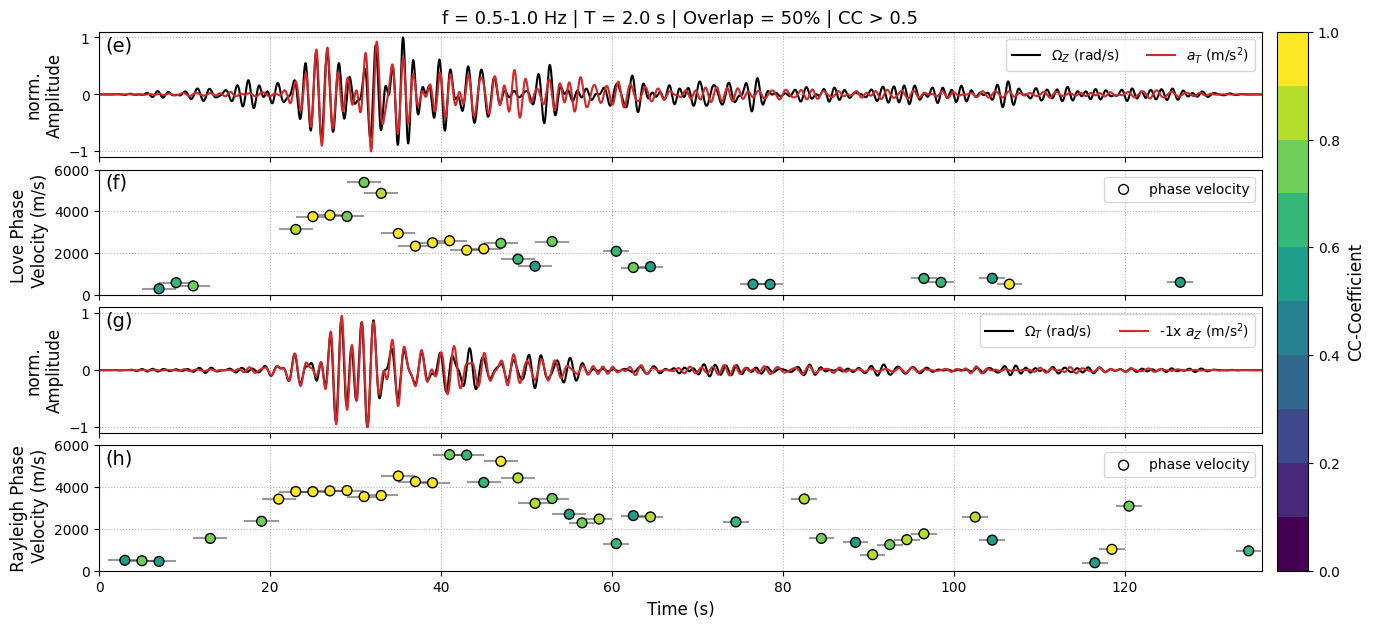

In [36]:
fig = __makeplotStream_velocities(rot, acc, fmin, fmax, baz,
                                  overlap=0.5, cc_threshold=0.5,
                                  reverse_rotZ=False, reverse_accZ=True,
                                 );

fig.savefig(config['path_to_figs']+f"BSPF_{config['name']}_velocities_{rot[0].stats.station}_{fmin}_{fmax}_2.png", dpi=200, bbox_inches='tight', pad_inches=0.05)
